# Exercise 1b: Nearest Neighbor Classification on Real Data

## Exploring the Data

In [1]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt

### Loading the data

In [2]:
digits = load_digits() 
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

### Structure and data types of the data

In [3]:
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

In [4]:
print(data.dtype)

float64


In total we have $1797$ images and each image is of size $8 \times 8 = 64$

In [5]:
data.shape

(1797, 64)

In [6]:
data[0, :].reshape((8,8))[0:5, 0:5]

array([[ 0.,  0.,  5., 13.,  9.],
       [ 0.,  0., 13., 15., 10.],
       [ 0.,  3., 15.,  2.,  0.],
       [ 0.,  4., 12.,  0.,  0.],
       [ 0.,  5.,  8.,  0.,  0.]])

### Visualization of some numbers

First let's visualize some number randomly.

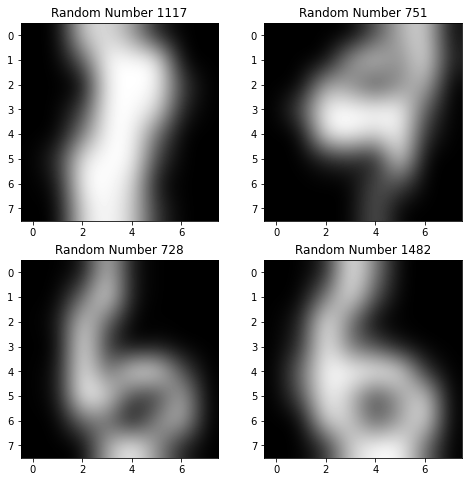

In [7]:
fig, axs = plt.subplots(2, 2)
sel = np.random.randint(low=0, high=1797, size=4)
for r, x, y in zip(sel, [0, 0, 1, 1], [0, 1, 0, 1]):
    img = data[r, :].reshape((8,8))
    assert 2 == len(img.shape)
    axs[x, y].imshow(img, interpolation="bicubic", cmap="gray")
    axs[x, y].set_title(f"Random Number {r}")
fig.set_size_inches(8, 8)

Now let's visualize the first two threes in the dataset (both with "nearest" and "bicubic" interpolation).

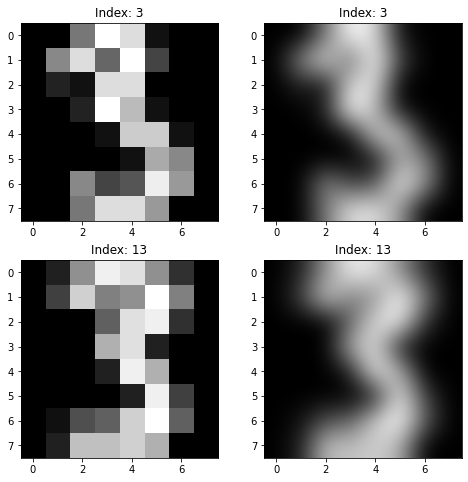

In [8]:
idx = np.argwhere(target == 3).flatten()[0:2].repeat(2)
fig, axs = plt.subplots(2, 2)
for r, x, y in zip(idx, [0, 0, 1, 1], [0, 1, 0, 1]):
    img = data[r, :].reshape((8,8))
    assert 2 == len(img.shape)
    ip = "nearest" if y == 0 else "bicubic"
    axs[x, y].imshow(img, interpolation=ip, cmap="gray")
    axs[x, y].set_title(f"Index: {r}")
fig.set_size_inches(8, 8)

Split test and train set.

In [9]:
from sklearn import model_selection
X_all = data
y_all = target
X_train, X_test, y_train, y_test = model_selection.train_test_split(digits.data, digits.target,
    test_size = 0.4, random_state = 0)

In [10]:
[array.shape for array in [X_train, X_test, y_train, y_test]]

[(1078, 64), (719, 64), (1078,), (719,)]

## 1.2 Distance function computation using loops

In [11]:
def dist_loop(training, test):
    """
    Computing distance matrix (euclidean distance)
     
    Parameters
    -------
    training : ndarray
        2D array (N x D) = N training instances with D features
    test : ndarray
        2D array (M x D) = M test instances with D features
        
    Returns
    -------
    ndarray
        2D array (N x M) = matrix containing the distances between each training instance
        and each test instance (element (i,j) is the distance between the ith training instance
        and the jth test instance)
    """
    N, M = training.shape[0], test.shape[0]
    distances = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            #distances[i,j] = np.sum((training[i,:] - test[j,:])**2)**0.5
            distances[i,j] = np.sqrt(np.sum(np.square(training[i,:] - test[j,:])))
    return distances

In [12]:
%timeit dist_loop(X_train, X_test)

4.57 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
distances = dist_loop(X_train, X_test)
#distances = dist_loop_Kathi(X_train, X_test)

In [14]:
distances.shape

(1078, 719)

In [15]:
distances[0:5, 0:5]

array([[55.67764363, 53.12249994, 56.56854249, 33.2565783 , 22.3383079 ],
       [47.51841748, 45.65084884, 48.72371086, 50.83306011, 49.76946855],
       [45.54119015, 53.72150407, 45.07771068, 56.32051136, 50.20956084],
       [49.30517214, 54.4885309 , 57.45432969, 49.70915409, 44.98888752],
       [44.95553359, 46.67976007, 25.03996805, 52.22068556, 49.13247399]])

Check by hand whether the first entry is correct (and indeed it is)

In [16]:
## check whether first entry is correct
np.sum((X_train[0,:] - X_test[0,:])**2)**0.5

55.67764362830022

## 1.3 Distance function computation using vectorization

### Defining the function

In [17]:
def dist_vec(training, test):
    """
    Computing distance matrix (euclidean distance)
     
    Parameters
    -------
    training : ndarray
        2D array (N x D) = N training instances with D features
    test : ndarray
        2D array (M x D) = M test instances with D features
        
    Returns
    -------
    ndarray
        2D array (N x M) = matrix containing the distances between each training instance
        and each test instance (element (i,j) is the distance between the ith training instance
        and the jth test instance)
    """
    N, M = training.shape[0], test.shape[0]

    # Repeating each instace of the training set M times
    expanded_training = np.repeat(training, M, axis = 0)

    
    # Concatenating M copies of the training matrix vertically
    expanded_test = np.tile(test, (N,1))
    
    # Computing the distance between the rowvectors of the expanded training and test matrix,
    # reshaping the results such that element (i,j) is the distance between training 
    # instance i and test instance j
    return (np.sum((expanded_training - expanded_test)**2, axis=1)**0.5).reshape((N,M))

The execution is faster by almost a factor of 10!

In [18]:
%timeit dist_vec(X_train, X_test)

426 ms ± 7.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
distances_2 = dist_vec(X_train, X_test)

In [20]:
distances_2.shape

(1078, 719)

In [21]:
N, M = X_train.shape[0], X_test.shape[0]
N * M

775082

The results of both functions are the same.

In [22]:
N * M - np.sum((distances_2 == distances))
#np.sum(distances_2 == distances)

0

### Briefly explaining the function

We first of all repeat each row in the training matrix M times results in a matrix of $(N \times M) \times D$. And the first M rows of the matrix will be first training example (see the first rows below - always the same numbers)

In [23]:
expanded_training = np.repeat(X_train, M, axis = 0)
expanded_training.shape

(775082, 64)

In [24]:
expanded_training[0:9, 0:5]

array([[ 0.,  0.,  0.,  8., 15.],
       [ 0.,  0.,  0.,  8., 15.],
       [ 0.,  0.,  0.,  8., 15.],
       [ 0.,  0.,  0.,  8., 15.],
       [ 0.,  0.,  0.,  8., 15.],
       [ 0.,  0.,  0.,  8., 15.],
       [ 0.,  0.,  0.,  8., 15.],
       [ 0.,  0.,  0.,  8., 15.],
       [ 0.,  0.,  0.,  8., 15.]])

Then, we stack the test matrix N times vertically resulting in a matrix of size $(M \times N) \times D$. So the first $M$ rows correspond to all M training examples (see the first 10 rows below - all different numbers)

In [25]:
expanded_test = np.tile(X_test, (N,1))
expanded_test.shape

(775082, 64)

In [26]:
expanded_test[0:9, 0:5]

array([[ 0.,  0., 11., 16., 15.],
       [ 0.,  1., 15., 14.,  2.],
       [ 0.,  2., 13., 16., 10.],
       [ 0.,  0.,  9.,  7.,  0.],
       [ 0.,  0.,  3., 13.,  6.],
       [ 0.,  0.,  5., 16., 12.],
       [ 0.,  0.,  0., 10., 13.],
       [ 0.,  0.,  2., 10., 13.],
       [ 0.,  0., 10., 14., 10.]])

Next we substract the second matrix from the first one (element-wise) resulting in a matrix of the same size 

In [27]:
expanded_training - expanded_test

array([[  0.,   0., -11., ...,  -8., -16.,  -8.],
       [  0.,  -1., -15., ...,   4.,   0.,   0.],
       [  0.,  -2., -13., ..., -11., -16.,  -3.],
       ...,
       [  0.,  -2.,  -9., ...,  -1.,  -8.,  -1.],
       [  0.,   0.,   5., ...,  11.,   0.,   0.],
       [  0.,   0.,   4., ...,   9.,   0.,   0.]])

Now we simply need to square each number, compute column sum, and then the square root. This results in a vector of length $N \times M$

In [28]:
not_reshaped = np.sum((expanded_training - expanded_test)**2, axis=1)**0.5
not_reshaped.shape

(775082,)

In the last step we need to reshape this vector into a matrix of size $N \times M$

In [29]:
reshaped = not_reshaped.reshape((N, M))
reshaped.shape

(1078, 719)

In [30]:
reshaped[0:5, 0:5]

array([[55.67764363, 53.12249994, 56.56854249, 33.2565783 , 22.3383079 ],
       [47.51841748, 45.65084884, 48.72371086, 50.83306011, 49.76946855],
       [45.54119015, 53.72150407, 45.07771068, 56.32051136, 50.20956084],
       [49.30517214, 54.4885309 , 57.45432969, 49.70915409, 44.98888752],
       [44.95553359, 46.67976007, 25.03996805, 52.22068556, 49.13247399]])

## 1.4 Implement the k-nearest neighbor classifier

### Preparing training and test set

In [31]:
train_ind = np.hstack([np.where(y_train == 3), np.where(y_train == 9)]).flatten()
test_ind = np.hstack([np.where(y_test == 3), np.where(y_test == 9)]).flatten()
(train_ind.shape, test_ind.shape)

((219,), (144,))

In [32]:
X_train_new, X_test_new, y_train_new, y_test_new = \
X_train[train_ind,:], X_test[test_ind,:], y_train[train_ind], y_test[test_ind]

In [33]:
X_test_new.shape

(144, 64)

### Defining the function

In [34]:
def knn(X_training, X_test, y_training, k):
    """
    K-nearest neigbor classifier via majority vote
     
    Parameters
    -------
    X_training : ndarray
        2D array (N x D) = N training instances with D features
    X_test : ndarray
        2D array (M x D) = M test instances with D features
    y_training : ndarray
        1D array (N) = lables of the N training instances
    k : int
        Number of neighbors to consider to classification
        
    Returns
    -------
    predicted_labels = ndarray
        1D array (M) = predicted labels of the M training instances
    """
    M = X_test.shape[0]
    distance_matrix = dist_vec(X_training, X_test)
    
    # Obtaining the k-nearest neighbors as column for each test instance,
    # resulting in a matrix of size k x M
    knn_index = np.argpartition(distance_matrix, kth=k, axis=0)[0:k,:]
    
    # get the labels for each training instance
    knn_labels = y_training[knn_index]
    
    # For each training instance i, apply np.bincount to the labels of the k nearest neighbors 
    # and then argmax to obtain the majority vote
    predicted_labels = np.array([np.bincount(knn_labels[:,i]).argmax() for i in range(M)])
    return predicted_labels

What does the function `np.bincount()` do? It creates bin for each integer from zero to the maximum value of the array. Using argmax we get the index with the highest count.

In [35]:
x = np.array([3,3,3,9,9,9,9,18])
print(x)
print(np.bincount(x))
print(np.bincount(x).argmax())

[ 3  3  3  9  9  9  9 18]
[0 0 0 3 0 0 0 0 0 4 0 0 0 0 0 0 0 0 1]
9


### Computing error rates

In [36]:
ks = np.array([1,3,5,9,17,33])
k_errors = np.zeros(len(ks))
for i in range(len(ks)):
    y_hat = knn(X_train_new, X_test_new, y_train_new, k=ks[i])
    k_errors[i] = np.mean(y_hat != y_test_new) * 100

And we basically get that same error rate for values of k between 3 and 17.

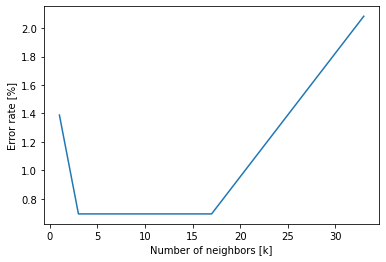

In [37]:
plt.plot(ks, k_errors)
plt.xlabel("Number of neighbors [k]")
plt.ylabel("Error rate [%]")
plt.show()

But what about values for k inbetween? With some k we can even reach an error rate of zero.

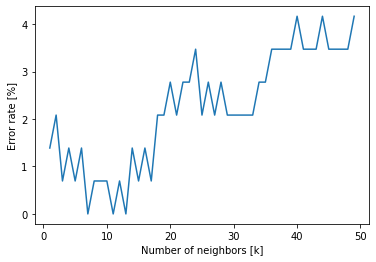

In [38]:
ks = np.arange(1,50)
k_errors = np.zeros(len(ks))
for i in range(len(ks)):
    y_hat = knn(X_train_new, X_test_new, y_train_new, k=ks[i])
    k_errors[i] = np.mean(y_hat != y_test_new) * 100

plt.plot(ks, k_errors)
plt.xlabel("Number of neighbors [k]")
plt.ylabel("Error rate [%]")
plt.show()

## 2 Cross-validation

### Defining the function

In [39]:
def split_folds(data, target, L):
    """
    Generating L folds for k-fold cross-validation
     
    Parameters
    -------
    data : ndarray
        2D array (N x D) = feature matrix
    target : ndarray
        1D array (N) = target vector
    L : int
        Number of folds
        
    Returns
    -------
    (X_folds, y_folds): tuple
        Tuple containing the folds of the feature matrix and 
        target vector as list of length L
    """
    N = data.shape[0]
    
    # Permuting the data
    p = np.random.permutation(target.shape[0])
    data_per, target_per = data[p], target[p]
    
    # Splitting the data into L folds
    X_folds = np.array_split(data_per, L)
    y_folds = np.array_split(target_per, L)
    return (X_folds, y_folds)

In [40]:
X_folds, y_folds = split_folds(data, target, L=10)

In [41]:
# Checking whether everything has the right shape
#[[fold.shape for fold in X_folds], [fold.shape for fold in y_folds]]

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
Ls = [2,5,10]
ks = [1,3,5,9,17,33]

In [44]:
k_errors = {}
for k in ks:
    own_errors = {}
    scikit_errors = {}
    for L in Ls:
        own_error_folds = np.zeros(L)
        scikit_error_folds = np.zeros(L)
        X_folds, y_folds = split_folds(data, target, L=L)
        inds = np.arange(0, L)
        for i in range(L):
            # Preparing training and test data for each fold
            X_training = np.concatenate([X_folds[j] for j in inds[inds != i]], axis=0)
            X_test = X_folds[i]
            y_training = np.concatenate([y_folds[j] for j in inds[inds != i]], axis=0)

            # Predictions with our knn implementation
            own_y_hat = knn(X_training, X_test, y_training, k)
            own_error_folds[i] = np.mean(own_y_hat != y_folds[i]) * 100

            # Predictions with scikit knn implementation
            scikit_knn = KNeighborsClassifier(n_neighbors=k)
            scikit_knn.fit(X_training, y_training)
            scikit_y_hat = scikit_knn.predict(X_test)
            scikit_error_folds[i] = np.mean(scikit_y_hat != y_folds[i]) * 100

        # Add the mean and var of the errors for a given L
        own_errors[L] = {"mean": np.mean(own_error_folds), "var": np.var(own_error_folds)}
        scikit_errors[L] = {"mean": np.mean(scikit_error_folds), "var": np.var(scikit_error_folds)}
    
    # Add those errors to the k dictionary
    k_errors[k] = (own_errors, scikit_errors)

Plotting the results of our own implementation:

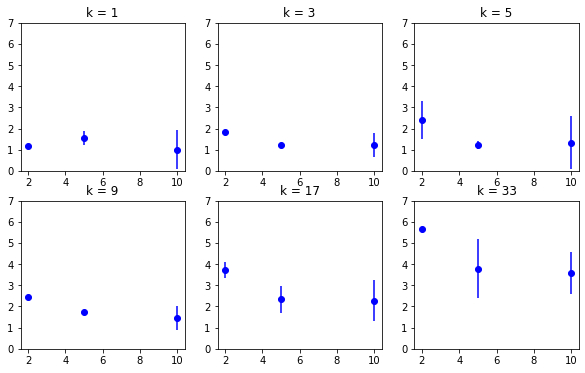

In [45]:
fig, axs = plt.subplots(2,3)
pos_dict = {1: (0,0), 3: (0,1), 5: (0,2), 9: (1,0), 17: (1,1), 33: (1,2)}
for k, both_errors in k_errors.items():
    own_error, scikit_error = both_errors
    pos = pos_dict[k]
    
    x_own = [l for l in own_error.keys()]
    x_scikit = [l for l in scikit_error.keys()]
    y_own = [value["mean"] for value in own_error.values()]
    y_scikit = [value["mean"] for value in scikit_error.values()]
    err_own = [value["var"] for value in own_error.values()]
    err_scikit = [value["var"] for value in own_error.values()]
    axs[pos].errorbar(x=x_own, y=y_own, yerr=err_own, fmt='o', color="blue")
    #axs[pos].errorbar(x=x_scikit, y=y_scikit, yerr=err_scikit, fmt='o', color="orange")
    axs[pos].set_title(f"k = {k}")
    axs[pos].set_ylim([0,7])
fig.set_size_inches(10, 6)

Plotting the results of the scikit implementation:

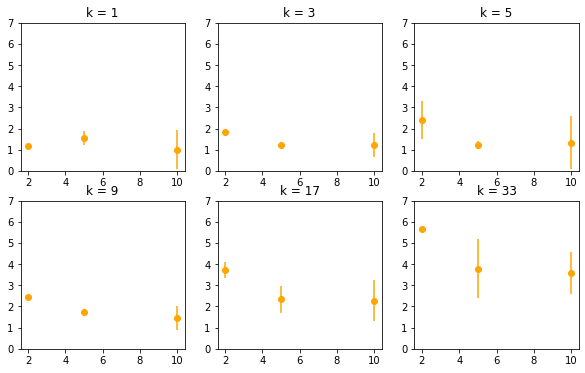

In [46]:
fig, axs = plt.subplots(2,3)
pos_dict = {1: (0,0), 3: (0,1), 5: (0,2), 9: (1,0), 17: (1,1), 33: (1,2)}
for k, both_errors in k_errors.items():
    own_error, scikit_error = both_errors
    pos = pos_dict[k]
    
    x_own = [l for l in own_error.keys()]
    x_scikit = [l for l in scikit_error.keys()]
    y_own = [value["mean"] for value in own_error.values()]
    y_scikit = [value["mean"] for value in scikit_error.values()]
    err_own = [value["var"] for value in own_error.values()]
    err_scikit = [value["var"] for value in own_error.values()]
    
    #axs[pos].errorbar(x=x_own, y=y_own, yerr=err_own, fmt='o', color="blue")
    axs[pos].errorbar(x=x_scikit, y=y_scikit, yerr=err_scikit, fmt='o', color="orange")
    axs[pos].set_title(f"k = {k}")
    axs[pos].set_ylim([0,7])
fig.set_size_inches(10, 6)

The results look exactly the same for both KNN implementations. For larger L (the number of folds used for cross-validation) the mean error gets smaller (which is true accross all values for k).

## Appendix

### Using Numba to speed up the functions (just-in-time compilation)

We think hard to vectorize a function, whereas we can simply use the for loop solution with Numba to get the same execution speed! (this is similar to Julia which is based on JIT)

In [47]:
from numba import jit

In [48]:
@jit(nopython=True)
def dist_loop_numba(training, test):
    N, M = training.shape[0], test.shape[0]
    distances = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            distances[i,j] = np.sum((training[i,:] - test[j,:])**2)**0.5
    return distances

In [49]:
%timeit dist_loop_numba(X_train, X_test)

39.6 ms ± 469 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%timeit dist_loop(X_train, X_test)

1.13 s ± 5.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%timeit dist_vec(X_train, X_test)

24.7 ms ± 441 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
